In [24]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/james/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [25]:
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
import itertools

## Mode finding for Isotropic Gaussian mixture model using mean-shift algorithm

The probability density function of a isotropic Gaussian mixture is:

$$p(\mathbf{x}) = \frac{1}{(2\pi)^{\frac{D}{2}}} \sum_{k=1}^K \frac{\pi_k}{\prod_{d=1}^D \sigma_{kd}}
\textrm{exp}\left( -\sum_{d=1}^D \frac{(x_d - \mu_{kd})^2}{2 \sigma_{kd}^2} \right)
$$

* $D$: number of dimensions for each Gaussian components
* $K$: number of components

The gradient of $p(\mathbf{x})$ w.r.t $x_{d}$ is:

$$\frac{\partial p(\mathbf{x})}{\partial x_d} = 
\frac{1}{(2\pi)^{\frac{D}{2}}} \sum_{k=1}^K \frac{\pi_k}{\prod_{j=1}^D \sigma_{kj}}
\textrm{exp}\left( -\sum_{j=1}^D \frac{(x_d - \mu_{kj})^2}{2 \sigma_{kj}^2} \right)
\frac{1}{\sigma_{kd}^2}(x_d - \mu_{kd})
$$

The modes of a Gaussian mixture model is found by setting $\frac{\partial p(\mathbf{x})}{\partial x_d} = 0$.

The update equation for $x_d$ is:
    
$$x_d^{(t+1)} = \frac{
\sum_{k=1}^K \frac{\pi_k}{\sigma_{kd}^2 \prod_{j=1}^D \sigma_{kj}}
\textrm{exp}\left( -\sum_{j=1}^D \frac{(x_d^{(t)} - \mu_{kj})^2}{2 \sigma_{kj}^2} \right)\mu_{kd}
}{
\sum_{k=1}^K \frac{\pi_k}{\sigma_{kd}^2 \prod_{j=1}^D \sigma_{kj}}
\textrm{exp}\left( -\sum_{j=1}^D \frac{(x_d^{(t)} - \mu_{kj})^2}{2 \sigma_{kj}^2} \right)
}
$$

In [26]:
class IsotropicGaussianMixture(object):
    def __init__(self, n_components=2, n_dim=1):
        self.n_components = n_components
        self.n_dim = n_dim
        self.pi = np.full(n_components, 1.0/n_components)
        self.sigma = np.ones((n_components, n_dim))
        self.mu = np.zeros((n_components, n_dim))
    
    def init_params(self):
        self.pi = np.random.dirichlet(alpha=[0.8]*self.n_components)
        self.mu = np.random.uniform(-3, 3, size=(self.n_components, self.n_dim))
        self.sigma = np.sqrt(np.random.gamma(shape=1, size=(self.n_components, self.n_dim)))
        return self
    
    def set_params(self, pi=None, mu=None, sigma=None):
        if pi is not None:
            self.pi = pi
        if mu is not None:
            self.mu = mu
        if sigma is not None:
            self.sigma = sigma
        return self
    
    def pdf(self, x):
        '''Calculate probability density of given points
        Args:
            x: ndarray of shape [n_dim] or [n_samples, n_dim]
        Returns:
            p: probality densities of given points
                if x is an ndarray of shape [n_dim], p is a scalar
                if x is an ndarray of shape [n_samples, n_dim], p is a 
        '''
        K, D = self.n_components, self.n_dim
        x = np.atleast_1d(x)
        if len(x.shape) == 1:
            assert x.shape[0] == D
            x = x.reshape((1, D))
            p_c = 1.0/np.power(2*np.pi, 0.5*D)/np.prod(self.sigma, axis=-1)
            p_c *= np.exp(-0.5*np.sum(np.square((x - self.mu)/self.sigma), axis=-1))
            p = np.sum(self.pi*p_c, axis=-1)
        else:
            assert x.shape[1] == D
            N = x.shape[0]
            x = x.reshape((N, 1, D))
            pi = self.pi.reshape((1, K))
            sigma = self.sigma.reshape((1, K, D))
            mu = self.mu.reshape((1, K, D))
            p_c = 1.0/np.power(2*np.pi, 0.5*D)/np.prod(sigma, axis=-1)
            p_c = p_c*np.exp(-0.5*np.sum(np.square((x - mu)/sigma), axis=-1))
            p = np.sum(pi*p_c, axis=-1)
        return p

    def __repr__(self):
        s = []
        s.append('n_components = {}'.format(self.n_components))
        s.append('n_dim = {}'.format(self.n_dim))
        s.append('pi = [{}]'.format(', '.join(self.pi.astype('str'))))
        for i in range(self.n_components):
            s.append('  mu[{:d}] = [{}]'.format(i, ', '.join(self.mu[i].astype('str'))))
            s.append('  sigma[{:d}] = [{}]'.format(i, ', '.join(self.sigma[i].astype('str'))))
        return '\n'.join(s)
    
    def mean_shift(self, x, tol=1e-6):
        '''Run mean-shift algorithm to find a mode
        Args:
            x: initial guess for a mode
            tol: absolute error in modes between iterations for defining convergence
        Returns:
            mode: ndarray of shape [n_dim]. Mode found.
        '''
        K, D = self.n_components, self.n_dim
        
        x_old = x
        while True:
            kernel = self.pi.reshape((K, 1))/np.prod(self.sigma, axis=1, keepdims=True)/np.square(self.sigma)
            kernel *= np.exp(-0.5*np.sum(np.square((x.reshape((1, D)) - self.mu)/self.sigma), axis=-1)).reshape((K, 1))
            x = np.sum(kernel*self.mu, axis=0)/np.sum(kernel, axis=0)
            if np.sqrt(np.sum(np.abs(x - x_old))) < tol:
                break
            x_old = x
        return x

    def find_modes(self, n_init=10, tol_mean_shift=1e-6, tol_merge_modes=1e-3):
        '''Find modes in the gaussian mixture model
        Args:
            n_init: number of random initializations
            tol_mean_shift: absolute error in modes between iterations for defining convergence
            tol_merge_modes: absolute error between modes for merging modes
        Returns:
            modes: ndarray of shape [n_modes, n_dim]. Modes found.
        '''
        K, D = self.n_components, self.n_dim
        # set range of high density region for finding modes
        range_min = np.min(self.mu - self.sigma)
        range_max = np.max(self.mu + self.sigma)
        modes = np.empty((0, D))
        for i in range(n_init):
            x = np.random.uniform(range_min, range_max, size=D)
            x_old = x
            n_iter = 0
            while True:
                n_iter += 1
                kernel = self.pi.reshape((K, 1))/np.prod(self.sigma, axis=1, keepdims=True)/np.square(self.sigma)
                kernel *= np.exp(-0.5*np.sum(np.square((x.reshape((1, D)) - self.mu)/self.sigma), axis=-1)).reshape((K, 1))
                x = np.sum(kernel*self.mu, axis=0)/np.sum(kernel, axis=0)
                if np.sum(np.abs(x - x_old)) < tol_mean_shift:
                    break
                x_old = x
            if len(modes) == 0:
                modes = np.append(modes, x.reshape((1, D)), axis=0)
            else:
                if np.min(np.sum(np.abs(x.reshape((1, D)) - modes), axis=1)) > tol_merge_modes:
                    modes = np.append(modes, x.reshape((1, D)), axis=0)
        return modes

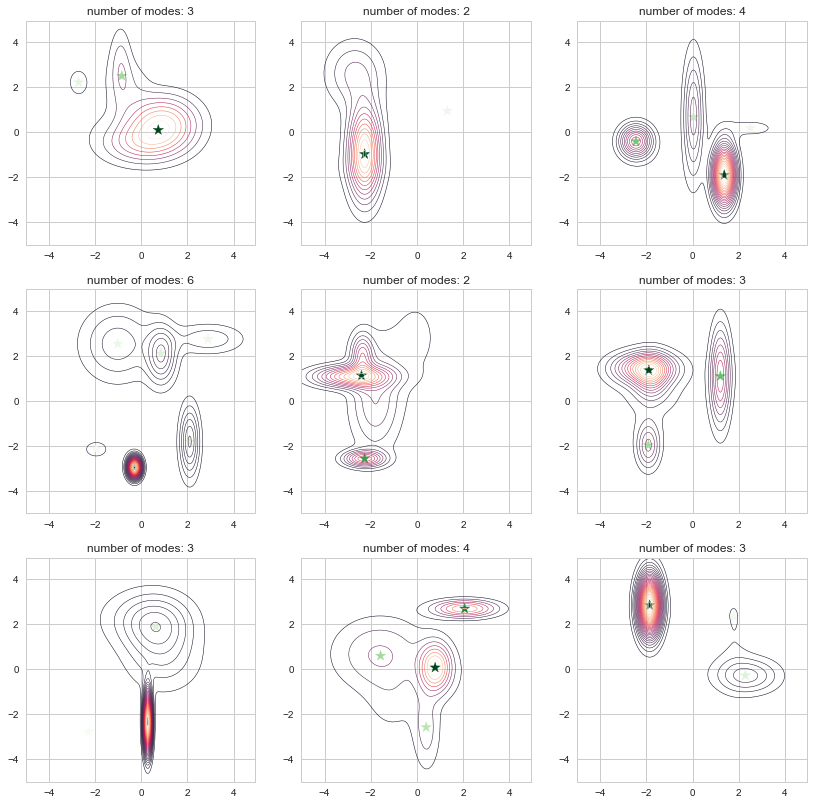

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(14, 14))
modess = {}
p_modess = {}
for i, j in itertools.product(range(3), range(3)):
    ax = axes[i, j]
    model = IsotropicGaussianMixture(n_components=6, n_dim=2)
    model.init_params()
    X_grid, Y_grid = np.mgrid[-5:5:0.05, -5:5:0.05]
    X = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
    ax.contour(X_grid, Y_grid, model.pdf(X).reshape(X_grid.shape), 
               linewidths=0.5, levels=np.linspace(0, 1, 80))
    modes = model.find_modes(n_init=30)
    ax.set_title('number of modes: {}'.format(modes.shape[0]))
    p_modes = model.pdf(modes)
    p_modess[i,j] = p_modes
    modess[i,j] = modes
    ax.scatter(modes[:, 0], modes[:, 1], s=120, label='modes', marker='*', c=p_modes/p_modes.max(),
              cmap=cm.Greens, norm=matplotlib.colors.NoNorm())

In [28]:
model

n_components = 6
n_dim = 2
pi = [0.013753936943202835, 0.009102476231493259, 0.7190702499095926, 0.018673011348102952, 0.17271147159307185, 0.06668885397453647]
  mu[0] = [-0.09725312361603544, 2.606472853600888]
  sigma[0] = [1.3305183933083997, 0.46558553356778326]
  mu[1] = [0.9077205011129759, 0.04018169056693566]
  sigma[1] = [0.612829186431448, 0.7025767488787488]
  mu[2] = [-1.8608467267568927, 2.853662997540109]
  sigma[2] = [0.33664803204170435, 0.88492185039491]
  mu[3] = [1.6940929158951041, 2.9662490162782102]
  sigma[3] = [1.6121924173683846, 1.393479925182139]
  mu[4] = [2.3998881084194723, -0.28968505037454584]
  sigma[4] = [0.9208852607238012, 0.5406793439626145]
  mu[5] = [1.8137859739340154, 1.8112441255420988]
  sigma[5] = [0.5203818976977337, 1.7806203492856196]

In [29]:
modess

{(0, 0): array([[ 0.74180264,  0.09300512],
        [-0.8367269 ,  2.49730972],
        [-2.70805702,  2.21463461]]),
 (0, 1): array([[-2.26115789, -0.97782395],
        [ 1.32429748,  0.94469863]]),
 (0, 2): array([[ 1.37018296, -1.90817181],
        [-2.45272575, -0.41336544],
        [ 2.49907207,  0.17797499],
        [ 0.03753897,  0.67264817]]),
 (1, 0): array([[-1.9456292 , -2.15646437],
        [-1.01173561,  2.53257873],
        [ 0.85502295,  2.10042193],
        [ 2.10135899, -1.81927015],
        [ 2.89412125,  2.74415224],
        [-0.2869135 , -2.96775549]]),
 (1, 1): array([[-2.40002565,  1.117028  ],
        [-2.26275327, -2.57347371]]),
 (1, 2): array([[-1.89517504,  1.35765401],
        [ 1.20225743,  1.08982455],
        [-1.91714135, -1.97879949]]),
 (2, 0): array([[ 0.62989616,  1.88503486],
        [-2.27296133, -2.77014941],
        [ 0.2859288 , -2.37466304]]),
 (2, 1): array([[ 0.78999488,  0.0773709 ],
        [-1.57217005,  0.60068358],
        [ 2.06988952, 

In [30]:
p_modess

{(0, 0): array([0.10998429, 0.04146531, 0.01335221]),
 (0, 1): array([0.15305338, 0.01229225]),
 (0, 2): array([0.27766414, 0.13741354, 0.01644648, 0.07040455]),
 (1, 0): array([0.01433482, 0.04608425, 0.08255035, 0.07822918, 0.0354568 ,
        0.51913546]),
 (1, 1): array([0.16854723, 0.11389387]),
 (1, 2): array([0.18541163, 0.09986748, 0.06793903]),
 (2, 0): array([0.07737623, 0.00292981, 0.48123577]),
 (2, 1): array([0.11187474, 0.04072357, 0.08908394, 0.03245526]),
 (2, 2): array([0.0589123 , 0.01324751, 0.38555186])}

In [31]:
def find_pmodes():
    modess = {}
    p_modess = {}
    for i, j in itertools.product(range(3), range(3)):
        model = IsotropicGaussianMixture(n_components=6, n_dim=2)
        model.init_params()
        modes = model.find_modes(n_init=30)
        p_modes = model.pdf(modes)
        p_modess[i,j] = p_modes
        modess[i,j] = modes
    return modess, p_modess

In [32]:
find_pmodes()

({(0, 0): array([[-0.27805237, -0.52395317],
         [ 0.31066384, -2.619106  ],
         [-2.76206738,  1.99833619],
         [ 1.86030626,  2.28702539]]),
  (0, 1): array([[-0.71929847,  2.99132027],
         [ 2.67094574, -2.53858302],
         [ 0.71884328,  2.49469704],
         [-1.88362184, -1.5589012 ],
         [ 2.87699273,  0.13191835]]),
  (0, 2): array([[ 0.33183434,  2.01965926],
         [-2.5531323 ,  2.24240056],
         [ 0.63232093, -2.05960858],
         [-2.38866784, -0.77889133]]),
  (1, 0): array([[ 0.03696204,  2.08884199],
         [ 1.79342979, -1.52836477],
         [-2.33993777, -1.75691717]]),
  (1, 1): array([[-1.34552496,  1.57522279],
         [ 0.21637835,  0.24731357],
         [ 2.87827401, -0.07646819],
         [-2.34458418, -1.75409615],
         [ 0.20301894,  1.48513118]]),
  (1, 2): array([[-0.89027229, -0.88208351],
         [-2.85747189,  0.17848196],
         [ 0.26461167,  0.45905394],
         [-2.93137936, -1.88360763],
         [-2.5639

In [33]:
def find_pmode():
    model = IsotropicGaussianMixture(n_components=6, n_dim=2)
    model.init_params()
    modes = model.find_modes(n_init=30)
    p_modes = model.pdf(modes)
    return modes, p_modes

In [34]:
find_pmode()

(array([[-0.8907437 , -1.03571654],
        [-2.66110046,  2.66644605],
        [-0.83680126,  2.71014611],
        [ 2.04117285, -0.15015866]]),
 array([0.01822311, 0.13220663, 0.12526797, 0.0707285 ]))

In [23]:
def get_predicion(pi,mu,sigma):
    model = IsotropicGaussianMixture(n_components=len(sigma), n_dim=2)
    model.set_params(pi,mu,sigma)
    modes = model.find_modes(n_init=30)
    p_modes = model.pdf(modes)
    index=np.where(p_modes==np.max(p_modes))
    return p_modes[index[0]], modes[index[0]]